<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/Toxicity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:2.3.1+cu121
cuda version: 12.1
cudnn version:8902


In [ ]:
!pip install rdkit-pypi
!pip install lifelines
#!pip install dgl-cu121 dglgo -f https://data.dgl.ai/wheels/repo.html #cuda version 필히 확인할 것 https://www.dgl.ai/pages/start.html 참조
!pip install dgllife
!pip install PyTDC

Looking in links: https://data.dgl.ai/wheels/repo.html
ERROR: Could not find a version that satisfies the requirement dgl-cu121 (from versions: none)
ERROR: No matching distribution found for dgl-cu121


In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 16.1 MB/s eta 0:00:00


In [ ]:
from tdc.single_pred import Tox
data = Tox(name = 'LD50_Zhu')
split = data.get_split()

Found local copy...
Loading...
Done!


<Axes: ylabel='Frequency'>

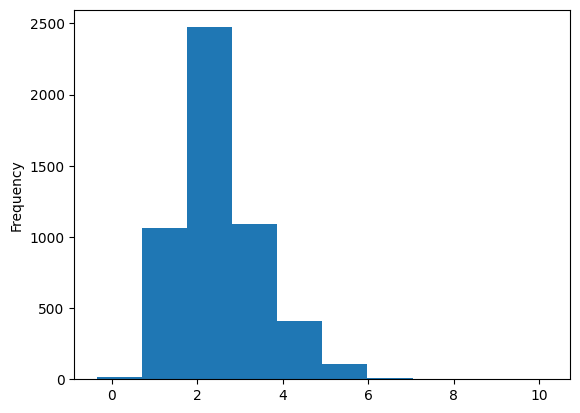

In [ ]:
split['train']['Y'].plot.hist()

In [ ]:
for mode in ['train', 'valid', 'test']:
    #print(mode, split[mode]['Y'].shape)
    split[mode]['embedding'] = split[mode]['Drug']

In [ ]:
split['train']

,Drug_ID,Drug,Y,embedding
0,"Methane, tribromo-",BrC(Br)Br,2.343,BrC(Br)Br
1,Bromoethene (9CI),C=CBr,2.330,C=CBr
2,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.465,Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br
3,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.729,S=C=Nc1ccc(Br)cc1
4,"Benzene, bromo-",Brc1ccccc1,1.765,Brc1ccccc1
...,...,...,...,...
5165,"Benzenesulfonic acid, 3,5-dimethyl-4-hydroxy-",Cc1cc(S(=O)(=O)O)cc(C)c1O,1.883,Cc1cc(S(=O)(=O)O)cc(C)c1O
5166,"Isocyanic acid, (alpha,alpha,alpha-trifluoro-o...",O=C=Nc1ccccc1C(F)(F)F,1.427,O=C=Nc1ccccc1C(F)(F)F
5167,"Propanenitrile, 3-((2-(acetyloxy)ethyl)phenyla...",CC(=O)OCCN(CCC#N)c1ccccc1,2.050,CC(=O)OCCN(CCC#N)c1ccccc1
5168,"IH-Indene-1,3(2H)-dione, 2-(2-methyl-1-(2-(1-p...",CC1=CC(=C2C(=O)c3ccccc3C2=O)C=CN1CCN1CCCCC1,2.951,CC1=CC(=C2C(=O)c3ccccc3C2=O)C=CN1CCN1CCCCC1


In [ ]:
from torch.utils import data
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from functools import partial
import torch
import dgl

In [ ]:
class data_process_loader(data.Dataset):
    def __init__(self, df):
        self.df = df

        self.node_featurizer = CanonicalAtomFeaturizer()
        self.edge_featurizer = CanonicalBondFeaturizer(self_loop=True)
        self.fc = partial(smiles_to_bigraph, add_self_loop=True)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        v_d = self.df.iloc[idx]['embedding']
        v_d = self.fc(smiles=v_d, node_featurizer=self.node_featurizer, edge_featurizer=self.edge_featurizer)
        y = self.df.iloc[idx]['Y']
        return v_d, y

In [ ]:
train_dataset = data_process_loader(split['train'])
valid_dataset = data_process_loader(split['valid'])
test_dataset = data_process_loader(split['test'])

In [ ]:
for v_d, y in train_dataset:
    print(v_d, y)
    break

Graph(num_nodes=4, num_edges=10,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)}) 2.343


In [ ]:
print(v_d.ndata['h'].shape)
v_d.ndata['h']

torch.Size([4, 74])


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 

In [ ]:
print(v_d.edata['e'].shape)
v_d.edata['e']

torch.Size([10, 13])


tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
v_d.batch_size

1

In [ ]:
def dgl_collate_fn(x):
    x, y = zip(*x)
    x = dgl.batch(x)
    y = torch.tensor(y)
    return x, y

In [ ]:
params = {'batch_size': 64,
        'shuffle': True,
        'num_workers': 0,
        'drop_last': False,
        'collate_fn' : dgl_collate_fn}

In [ ]:
train_loader = data.DataLoader(train_dataset, **params)
valid_loader = data.DataLoader(valid_dataset, **params)
test_loader = data.DataLoader(test_dataset, **params)

In [ ]:
for v_d, y in train_loader:
    print(v_d)
    print(v_d.batch_size)
    print(y)
    break

Graph(num_nodes=1060, num_edges=3270,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)})
64
tensor([0.7550, 3.0860, 4.3680, 2.6310, 2.4740, 3.2100, 1.9340, 2.3780, 1.5570,
        1.3720, 3.5830, 1.7470, 1.9920, 2.8260, 2.7400, 3.6200, 4.1340, 1.1060,
        3.5590, 1.1520, 1.6590, 2.3050, 1.3480, 1.9200, 2.3300, 2.7930, 1.2930,
        2.6180, 2.7130, 5.1040, 2.3200, 0.4770, 2.0900, 2.4480, 2.8640, 1.5040,
        2.3880, 2.1120, 2.3500, 3.6360, 2.6670, 2.4920, 3.3660, 1.5410, 3.4360,
        1.8790, 4.0330, 0.8440, 1.8620, 2.1390, 2.2120, 2.9570, 1.7850, 2.3430,
        2.1360, 2.3180, 4.2720, 3.8270, 1.6950, 2.7270, 5.1040, 1.4750, 3.0560,
        0.6180], dtype=torch.float64)


In [ ]:
import torch.nn.functional as F
from torch import nn
from dgllife.model.gnn.gcn import GCN
from dgllife.model.readout.weighted_sum_and_max import WeightedSumAndMax

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
config = {"gnn_hid_dim_drug" : 64,
          "gnn_num_layers" : 3,
          "gnn_activation" : F.relu,
          "hidden_dim_drug" : 256,
          "cls_hidden_dims" : [1024, 1024, 512]}

In [ ]:
class DGL_GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats=None, activation=None, predictor_dim=None):
        super(DGL_GCN, self).__init__()

        self.gnn = GCN(in_feats=in_feats,
						hidden_feats=hidden_feats,
						activation=activation)
        gnn_out_feats = self.gnn.hidden_feats[-1]
        self.readout = WeightedSumAndMax(gnn_out_feats)
        self.transform = nn.Linear(gnn_out_feats*2, predictor_dim)

    def forward(self, g):
        g = g.to(device)
        feats = g.ndata.pop('h')
        h = self.gnn(g, feats)
        h = self.readout(g, h)
        h = self.transform(h)
        return h

In [ ]:
class Classifier(nn.Sequential):
    def __init__(self, model_drug):
        super(Classifier, self).__init__()
        self.model_drug = model_drug

        self.input_dim_drug = config['hidden_dim_drug']
        self.hidden_dims = config['cls_hidden_dims']

        layer_size = len(self.hidden_dims) + 1
        dims = [self.input_dim_drug] + self.hidden_dims +[1]

        self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

        self.dropout = nn.Dropout(0.1)

    def forward(self, v_D):
        h_D = self.model_drug(v_D)

        for i, l in enumerate(self.predictor):
            if i==(len(self.predictor)-1):
                h_D = l(h_D)
            else:
                h_D = F.relu(self.dropout(l(h_D)))
        return h_D

In [ ]:
model_drug = DGL_GCN(in_feats = 74,
									hidden_feats = [config['gnn_hid_dim_drug']] * config['gnn_num_layers'],
									activation = [config['gnn_activation']] * config['gnn_num_layers'],
									predictor_dim = config['hidden_dim_drug'])

In [ ]:
model = Classifier(model_drug)
model = model.to(device)

In [ ]:
import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index
from scipy.stats import pearsonr

In [ ]:
lr = 0.0001
decay = 0.00001
max_MSE = 10000
epoch = 20

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

loss_fn = torch.nn.MSELoss()

In [ ]:

loss_history = [] # loss 저장할 list

model_max = copy.deepcopy(model) # 최고 성능 모델 deepcopy

# valid metric 기록
valid_metric_record = []
valid_metric_header = ["# epoch"]
valid_metric_header.extend(["MSE", "Pearson Correlation", "with p-value", "Concordance Index"])

table = PrettyTable(valid_metric_header)
float2str = lambda x:'%0.4f'%x

print('--- Go for Training ---')

### 학습 시작
t_start = time()

for epo in range(epoch):

  ## Training
  model.train()

  for i, (v_d, label) in enumerate(train_loader):
    v_d = v_d
    score = model(v_d)
    n = torch.squeeze(score, 1)
    loss = loss_fn(n.float(), label.float().to(device))

    loss_history.append(loss.item())

    # gradient 초기화 -> back-propagation -> parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  with torch.set_grad_enabled(False):
    y_pred = []
    y_label = []

    ## Validation
    model.eval()

    for i, (v_d, label) in enumerate(valid_loader):
      v_d = v_d.to(device)
      score = model(v_d)
      logits = torch.squeeze(score, 1).cpu().detach().numpy()
      label_ids = label.to('cpu').numpy()
      y_label = y_label + label_ids.flatten().tolist()
      y_pred = y_pred + logits.flatten().tolist()


  ## metric 계산
  # Mean Square Error
  mse = mean_squared_error(y_label, y_pred)
  # Pearson corrleation coefficient
  r2 = pearsonr(y_label, y_pred)[0] # coefficient
  p_val = pearsonr(y_label, y_pred)[1] # p-value
  # concordace index
  CI = concordance_index(y_label, y_pred)

  logits = y_pred

  # metric 저장
  lst = ["epoch " + str(epo)] + list(map(float2str,[mse, r2, p_val, CI]))
  valid_metric_record.append(lst)

  # max MSE, max model update
  if mse < max_MSE:
    model_max = copy.deepcopy(model)
    max_MSE = mse

  print('Validation at Epoch '+ str(epo + 1) + ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
						 + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])

  table.add_row(lst)



--- Go for Training ---
Validation at Epoch 1 , MSE: 0.50831 , Pearson Correlation: 0.69314 with p-value: 9.48E-107 , Concordance Index: 0.74460
Validation at Epoch 2 , MSE: 0.47445 , Pearson Correlation: 0.73319 with p-value: 2.18E-125 , Concordance Index: 0.75694
Validation at Epoch 3 , MSE: 0.53476 , Pearson Correlation: 0.70606 with p-value: 2.05E-112 , Concordance Index: 0.74757
Validation at Epoch 4 , MSE: 0.45675 , Pearson Correlation: 0.73036 with p-value: 5.84E-124 , Concordance Index: 0.75574
Validation at Epoch 5 , MSE: 0.49852 , Pearson Correlation: 0.71828 with p-value: 4.52E-118 , Concordance Index: 0.75280
Validation at Epoch 6 , MSE: 0.45424 , Pearson Correlation: 0.73615 with p-value: 6.67E-127 , Concordance Index: 0.75779
Validation at Epoch 7 , MSE: 0.47013 , Pearson Correlation: 0.71954 with p-value: 1.15E-118 , Concordance Index: 0.75174
Validation at Epoch 8 , MSE: 0.50077 , Pearson Correlation: 0.73256 with p-value: 4.55E-125 , Concordance Index: 0.75853
Validati

In [ ]:
for i, (v_d, label) in enumerate(test_loader):
    print(v_d)
    print(v_d.batch_size)
    print(label)
    break

Graph(num_nodes=1074, num_edges=3276,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)})
64
tensor([1.4710, 4.6840, 2.1300, 2.9370, 3.7590, 3.2730, 3.0120, 4.5520, 1.7680,
        1.7590, 3.5320, 1.7300, 2.3110, 1.3360, 2.1950, 3.1080, 2.6590, 5.0640,
        1.5220, 2.4120, 2.7130, 1.6280, 3.4740, 3.0730, 2.0300, 0.8180, 2.0970,
        1.5160, 3.6960, 4.7610, 1.9820, 5.0100, 2.3660, 2.5080, 2.1560, 2.9860,
        2.0290, 1.4910, 3.0350, 1.7700, 3.0860, 2.2560, 2.0530, 2.6350, 2.3420,
        1.4660, 3.8530, 4.0390, 1.2150, 2.5610, 4.4460, 1.2070, 2.8930, 2.2100,
        2.7980, 3.0680, 1.9630, 1.3290, 2.1320, 2.6660, 3.3380, 4.1010, 4.1430,
        2.0900], dtype=torch.float64)


In [ ]:
y_pred_test = []
y_label_test = []

model_max.eval()

with torch.set_grad_enabled(False):
    for i, (v_d, label) in enumerate(test_loader):
        v_d = v_d.to(device)

        score = model_max(v_d)
        logits = torch.squeeze(score, 1).cpu().detach().numpy()
        label_ids = label.to('cpu').numpy()
        y_label_test = y_label_test + label_ids.flatten().tolist()
        y_pred_test = y_pred_test + logits.flatten().tolist()

In [ ]:
mse = mean_squared_error(y_label_test, y_pred_test)
r2 = pearsonr(y_label_test, y_pred_test)[0]
p_val = pearsonr(y_label_test, y_pred_test)[1]
CI = concordance_index(y_label_test, y_pred_test)

print('MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
						 + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])

MSE: 0.39401 , Pearson Correlation: 0.76842 with p-value: 3.06E-288 , Concordance Index: 0.76334


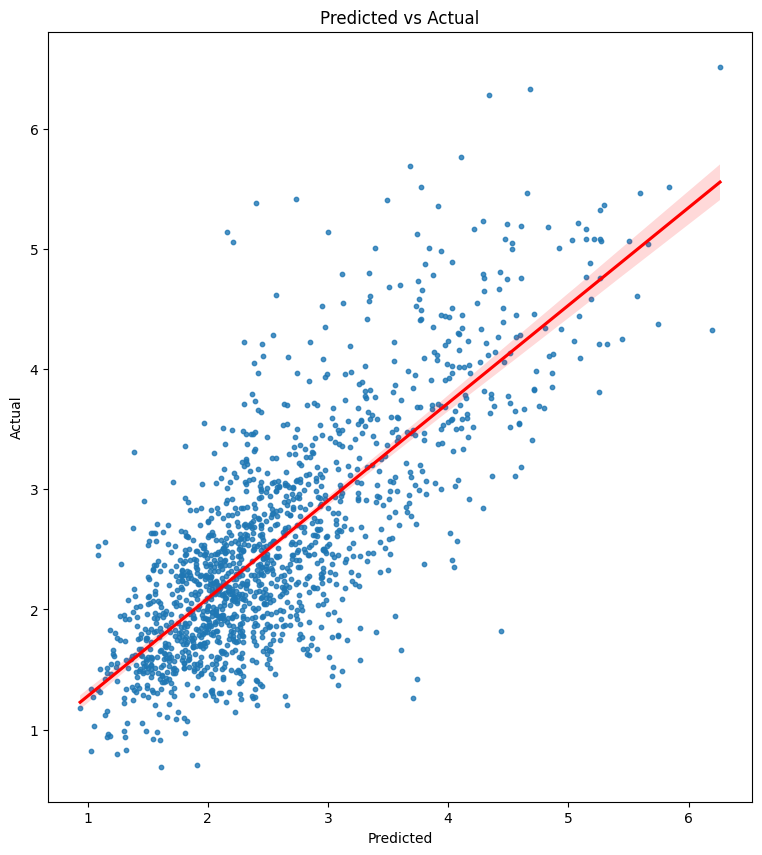

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.regplot(x=y_pred_test, y=y_label_test, scatter_kws={'s':10}, line_kws={'color':'r'}, fit_reg=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual')

ax.set_aspect('equal')

plt.show()